In [16]:
# Import dependencies

import numpy as np

import torch
import random

%load_ext autoreload
%autoreload 2

SEED = 42
torch.manual_seed(42)  # Fixes the seed for PyTorch
np.random.seed(42)  # Fixes the seed for NumPy
random.seed(42)  # Fixes the seed for Python's random module

SLIDING_WINDOW_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Load data
import helpers
import os
import pandas as pd

action_folders = [
    "badminton",
    "boxing",
    "fencing",
    "golf",
    "logout",
    "reload",
    "shield",
    "snowbomb",
]
tuples = []
test_tuples = []

for idx, folder in enumerate(action_folders):
    data_path = os.path.join("dataset", folder)
    for csv_file in os.listdir(data_path):
        dataframe = pd.read_csv(os.path.join(data_path, csv_file))
        if csv_file == "test.csv":
            test_tuples.append((dataframe, idx))
        else:
            tuples.append((dataframe, idx))

x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride=SLIDING_WINDOW_SIZE)
# x_test, y_test = helpers.generate_data(test_tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride = SLIDING_WINDOW_SIZE)


print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (979, 10, 6)
Shape of output vector is (979,)


In [18]:
# Split data
from sklearn.model_selection import train_test_split

# raw_x_train, raw_x_test, y_train, y_test = x, x_test, y, y_test

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (685, 10, 6)
Shape of y_train is (685,)
Shape of raw_x_test is (294, 10, 6)
Shape of y_test is (294,)


In [19]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (685, 108)
Shape of testing feature vector is (294, 108)


In [20]:
# Normalize data

from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print("Shape of training feature vector is " + str(x_train.shape))
print("Shape of testing feature vector is " + str(x_test.shape))

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

Shape of training feature vector is (685, 108)
Shape of testing feature vector is (294, 108)


Epoch 0 Loss 2.0779335498809814
Epoch 100 Loss 1.3580071926116943
Epoch 200 Loss 1.3342541456222534
Epoch 300 Loss 1.3295884132385254
Epoch 400 Loss 1.3276280164718628
Epoch 500 Loss 1.3259040117263794
Epoch 600 Loss 1.324542760848999
Epoch 700 Loss 1.3239268064498901
Epoch 800 Loss 1.3236162662506104
Epoch 900 Loss 1.3234703540802002
Epoch 1000 Loss 1.323353886604309
Epoch 1100 Loss 1.3232766389846802
Epoch 1200 Loss 1.3231918811798096
Epoch 1300 Loss 1.3231191635131836
Epoch 1400 Loss 1.3230042457580566
Accuracy on training set is 0.997080291970803


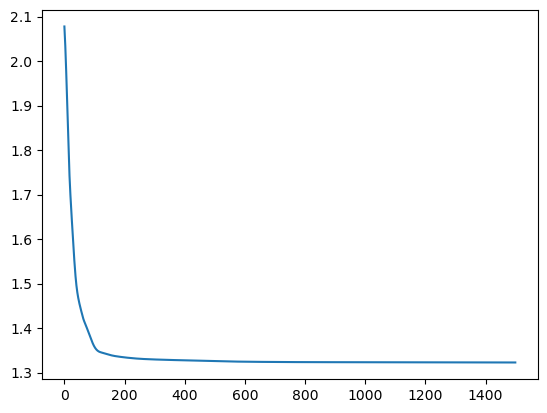

In [21]:
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, len(action_folders)),
    nn.Softmax(dim=1),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")

model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

[7 1 7 0 2 7 0 1 7 7 6 5 7 7 1 1 7 7 1 1 7 6]
Accuracy on testing set is 0.9897959183673469
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        27
           5       1.00      0.97      0.98        29
           6       0.93      1.00      0.96        37
           7       1.00      0.94      0.97        35

    accuracy                           0.99       294
   macro avg       0.99      0.99      0.99       294
weighted avg       0.99      0.99      0.99       294



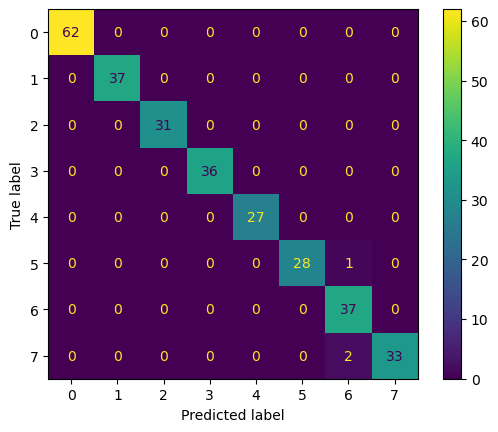

In [22]:
# Evaluate the model

model.eval()
y_pred = model(
    torch.tensor(x_test).float()
)  

# Convert matrix values to 0 if below 0.7
y_max = torch.max(y_pred, dim=1)
y_pred = torch.argmax(y_pred, dim=1)

# Get indices where y_max is less than 0.7 and see the y_test of those indices
indices = y_max.values < 0.7
print(y_test[indices])

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(len(action_folders)))

display.plot()

In [23]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {-0.0055967336520552635,0.0035742437466979027,0.022006899118423462,-0.025726500898599625,0.007747139781713486,-0.03201178461313248,0.04168467968702316,-0.008272486738860607,0.0045263497158885,0.017779413610696793,0.0017885700799524784,0.0016428313683718443,0.022655798122286797,-0.002271670149639249,0.017217101529240608,0.00522112799808383,-0.0005625599878840148,0.0002807766431942582,0.04136365279555321,-0.008155322633683681,-0.016606971621513367,0.030058465898036957,-0.013347757048904896,0.01577300764620304,0.01754547283053398,-0.008581999689340591,-0.024996481835842133,0.017379937693476677,-0.019575849175453186,0.005897561553865671,0.018679555505514145,0.0014359722845256329,-0.006123736500740051,0.006250354461371899,-0.00206574285402894,0.0199182890355587,1.0323048627469689e-05,-0.006595478393137455,-0.02341129258275032,0.004364055581390858,-0.020737584680318832,-0.002535315928980708,-0.00338342459872365,-0.0089277690276503

In [24]:
# Generate test cases for HLS

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)
single_test_case = test_cases[12]

raw_output = model(torch.tensor(test_cases).float()).detach().numpy()
pred_output = np.argmax(raw_output, axis=1)
single_pred_output = pred_output[12]

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {-0.9587760282058642,-2.2948290052618296,-1.8418188183696345,-1.4649387360753754,1.1930495678725956,-1.3110759134689844,-0.1114117227471306,1.8141311857212776,-0.8082091818911765,-0.644330802430908,1.3105943064934806,1.4734445727905494,-0.9118191476455613,-2.233577981903791,-1.3922137060917632,-1.6253855697176636,1.3072729757400212,1.5795437010428703,1.4056696532447344,2.277259737408734,1.478582996379756,0.9393961708257154,0.6836744148374804,1.41078579028769,1.1631239309751993,1.9342283694230444,1.543155233765079,1.4029260813318662,0.9282719701133146,1.3828145130046208,1.8384305230559483,5.377645679943538,-0.09147142439478047,0.8911130615292572,-0.32192474793532905,4.890108835331693,0.8695605592904908,0.53520005622622,1.433121437188473,1.3804841459899977,0.9249703791879085,0.8492582855220333,0.978727358641622,1.7389327857466368,1.5882038480517746,1.4307046503195398,0.7647250079983912,1.381418611203042,-1.4294308213155644,0.740851068642

In [25]:
# Generate single test case for pynq testing

TEST_CASES = 3

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)
    
pred_output = model(torch.tensor(test_cases).float()).detach().numpy()

pred_output = np.argmax(pred_output, axis=1)

test_cases = np.array(test_cases)


test_cases_str = "input = ["
pred_output_str = "output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

input = [-0.9587760282058642, -0.05852457580143628, -1.8418188183696345, -1.4649387360753754, 1.4301461399852122, 0.8868614455744638, -0.30686210910705214, 0.795405463985083, -0.6591245285936099, -1.467353984064706, 1.3105943064934806, 1.4734445727905494, -1.058623291078957, -0.8602002524522199, -1.0960543570725683, -1.4130088351275583, 1.7704769406225538, 1.9661882627953098, 1.1782571951158964, 0.40639491539949635, 1.242339164988218, -0.3131905484955019, 0.3687640326325854, 0.5965195972376022, 1.2928045826022267, -0.21275902084773834, 1.2144867492229132, 0.6564714221697789, 1.3405477514559399, 1.2576600594715504, 0.5715790567542022, -0.21088056123802246, 2.6037471466124913, 0.0849420633706187, 1.0768673200092271, 0.8271646594846981, 1.1299627777847627, -0.6080859456259314, 1.1222541751460173, 1.0541265377954991, 1.6408423715683564, 1.4293821723262954, 1.2429745544988549, -0.47933827324368533, 1.1257115690970265, 0.6466002098452795, 1.5887051777093348, 1.5747562294916027, -1.4294308213

C:\Users\tohmi\AppData\Local\Temp\ipykernel_6696\2179887874.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  pred_output = model(torch.tensor(test_cases).float()).detach().numpy()
